In [2]:
!pip install pyro-ppl torch gpytorch

     |████████████████████████████████| 678 kB 4.3 MB/s 
     |████████████████████████████████| 503 kB 49.6 MB/s 


In [1]:
import torch
import gpytorch
import random
import numpy as np
from gpytorch.priors import GammaPrior, UniformPrior, NormalPrior

import pyro
from pyro.infer.mcmc import NUTS, HMC, MCMC

import matplotlib.pyplot as plt

#from exactgpmodel import ExactGPModel


%matplotlib inline
torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
def get_mixture_stds(means, stds):
    """
    Return standard deviation of a k-component Gaussian mixture model, given an
    (k x n) array of k component means for n locations, and a (k x n) array of
    k component stds for n locations.
    """
    mixture_means = np.mean(means, axis=0)
    sums_squared_means_stds = means ** 2 + stds ** 2
    second_moments = np.mean(sums_squared_means_stds, axis=0)
    mixture_vars = second_moments - mixture_means ** 2
    mixture_stds = np.sqrt(mixture_vars)
    return mixture_stds

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
from IPython.core.display import clear_output
def evaluate_acq_fn(x, y, priors=(1,1,1,1,1,1), num_hyper_samples=500, warmup_steps=300, num_post_pred=20):
    # add option to set bounds
    # switch train to x and y
    train_x = x
    train_y = y

    ###########
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())

    model = ExactGPModel(train_x, train_y, likelihood)

    # register priors
    model.covar_module.base_kernel.register_prior("lengthscale_prior", GammaPrior(priors[0],priors[1]), "lengthscale")
    model.covar_module.register_prior("outputscale_prior", GammaPrior(priors[2],priors[3]), "outputscale")
    likelihood.register_prior("noise_prior", GammaPrior(priors[4],priors[5]), "noise") 

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # MCMC sampling
    num_hyper_samples =  num_hyper_samples
    warmup_steps = warmup_steps

    def pyro_model(x, y):
      with gpytorch.settings.fast_computations(False, False, False):
          sampled_model = model.pyro_sample_from_prior()
          output = sampled_model.likelihood(sampled_model(x))
          pyro.sample("obs", output, obs=y)
      return y

    nuts_kernel = NUTS(pyro_model, adapt_step_size=True)
    mcmc_run = MCMC(nuts_kernel, num_samples=num_hyper_samples, warmup_steps=warmup_steps)
    mcmc_run.run(train_x, train_y)

    hyperparam = list(mcmc_run.get_samples().keys())

    kl_samples = mcmc_run.get_samples()[hyperparam[0]]
    kv_samples = mcmc_run.get_samples()[hyperparam[1]]
    nv_samples = mcmc_run.get_samples()[hyperparam[2]]

    parameter_samples = [kl_samples, kv_samples, nv_samples]

    # acquisition function loop to obtain equation term values
    NUM_POST_PRED = num_post_pred
    sampled_hyper_indx = []

    # np.random.seed(2) # ensures we are working with same indices  

    # DIFFERENT TEST INDICES OF SAMPLED HYPERPARAMS OF SIZE NUM_POST_PRED:
    for i in range(NUM_POST_PRED):
      sampled_hyper_indx.append(np.random.randint(0,num_hyper_samples))

    # TESTING POINTS (INPUT):
    n = 100
    x = np.linspace(-1, 1, n)
    y = np.linspace(-1, 1, n)

    xx, yy = np.meshgrid(x, y)
    test_points = torch.Tensor( np.vstack([xx.ravel(), yy.ravel()]).T )

    num_test = test_points.shape[0]

    # DIFFERENT TEST INDICES OF SAMPLED HYPERPARAMS:
    means = []
    stds = []
    entropies = []

    for indx in sampled_hyper_indx:
      # CREATE GPR MODEL:
      likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive()) 
      m = ExactGPModel(train_x, train_y, likelihood)   

      hypers = {
          hyperparam[0][:-6]: parameter_samples[0][indx].numpy()[0][0], #l
          hyperparam[1][:-6]: parameter_samples[1][indx].numpy(),       #v
          hyperparam[2][:-6]: parameter_samples[2][indx].numpy()[0] } #n

      # assign hyperparams from sampled hyperparam distributions:
      m.initialize(**hypers)

      # OBTAIN MEAN AND VARIANCE OF F AT A POINTS "test_points"
      m.eval()                                                      
      with torch.no_grad():
        predictions = m(test_points)  
        mean = predictions.mean.detach().numpy()
        var = predictions.variance.detach().numpy()

      mean = np.squeeze(mean)
      std = np.sqrt( np.squeeze(var) )

      means += [mean]
      stds += [std]

      # CREATE GAUSSIAN DISTRIBUTIONS WITH MEAN AND VARIANCES AND FIND ENTROPY:
      e = [] # holds entropies for "num_test" distributions
      import torch.distributions as tdist
      for i in range(num_test):
        distribution_2 = tdist.Normal(mean[i], var[i])
        e.append(distribution_2.entropy().detach().numpy())

      entropies.append(e)

    # final results
    means = np.array(means)
    stds = np.array(stds)
    entropies = np.array(entropies)

    # COMPUTATIONS TO OBTAIN 1ST TERM IN EQUATION:
    mixture_means = np.mean(means, axis=0)
    mixture_stds = get_mixture_stds(means, stds)

    distribution_1 = tdist.Normal(torch.tensor(np.array(mixture_means)), torch.tensor(np.array(mixture_stds)))

    entropy_of_avg = distribution_1.entropy().detach().numpy().reshape(-1,1)

    # clear cell output
    #clear_output(wait=True)

    # COMPUTATIONS TO OBTAIN 2ND TERM IN EQUATION:
    avg_entropy = np.mean(entropies, axis=0).reshape(-1,1)

    # stick in variable:
    #print(f"ENTROPY OF AVG (1st term): {entropy_of_avg}")
    #print(f"AVG OF ENTROPY (2nd term): {avg_entropy}")

    acq_value = entropy_of_avg - avg_entropy
    acq_opt_idx = np.argmax(acq_value)
    # print(f"Acq val: {acq_value}")
    # print(f"Acq max: {np.max(acq_value)}")
    # print(f"Acq idx: {acq_opt_idx}")

    mat_idx_1 = int(acq_opt_idx / 100)
    mat_idx_2 = acq_opt_idx - (mat_idx_1 * 100)

    print(f"Next sample: {xx[mat_idx_1, mat_idx_2]:.2f}, {yy[mat_idx_1, mat_idx_2]:.2f}")

    print(f"lengthscale: {np.mean(np.array(parameter_samples[0])):.4f}, {np.std(np.array(parameter_samples[0])):.4f}")
    print(f"outputscale: {np.mean(np.array(parameter_samples[1])):.4f}, {np.std(np.array(parameter_samples[1])):.4f}")
    print(f"noise: {np.mean(np.array(parameter_samples[2])):.4f}, {np.std(np.array(parameter_samples[2])):.4f}")

    plt.figure(figsize=(4, 4))
    plt.rc('font', size=12)  
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.pcolor(xx,yy,acq_value.reshape(n,n))
    plt.plot(input_xy[:,0], input_xy[:,1], 'o', color='k')
    plt.plot(xx[mat_idx_1, mat_idx_2], yy[mat_idx_1, mat_idx_2], '*', c="magenta", markersize=10)
    cbar = plt.colorbar()
    cbar.set_label("EIG(x1 , x2)")
    plt.show()
    plt.close()

    return xx[mat_idx_1, mat_idx_2], yy[mat_idx_1, mat_idx_2], (np.mean(np.array(parameter_samples[0])), np.std(np.array(parameter_samples[0])), \
     np.mean(np.array(parameter_samples[1])), np.std(np.array(parameter_samples[1])),  np.mean(np.array(parameter_samples[2])), np.std(np.array(parameter_samples[2])))

In [54]:
def Z(x,y):
  return np.exp(-(x**2+y**2)/2) 

In [55]:
x = np.linspace(-1,1,100)
y = np.linspace(-1,1,100)

X,Y = np.meshgrid(x, y) 
 

input_xy = np.array([[random.uniform(-1,1) for i in range(2)] for j in range(5)])
z = Z(input_xy[:,0], input_xy[:,1])

input_xy = torch.Tensor(input_xy)

train_x = input_xy
train_y = torch.Tensor(z)


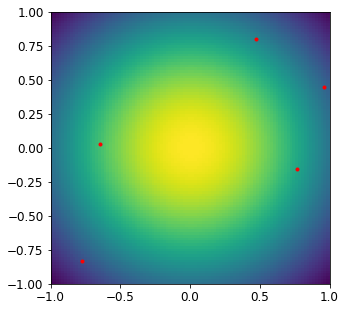

In [56]:
plt.figure(figsize=(5,5))
plt.pcolor(X, Y, Z(X,Y))
plt.plot(input_xy[:,0], input_xy[:,1], color="red", linewidth=0, marker=".")

Iter: 0 out of 5


Sample: 100%|██████████| 900/900 [01:19, 11.28it/s, step size=6.06e-01, acc. prob=0.923]


Acq val: [[1.62417196]
 [1.63889842]
 [1.65323312]
 ...
 [1.64872744]
 [1.6378952 ]
 [1.62695268]]
Acq max: 2.231622433992013
Acq idx: 6784
Next sample: 0.70, 0.35
lengthscale: 2.1029, 1.3148
outputscale: 0.6079, 0.5655
noise: 0.1789, 0.2910


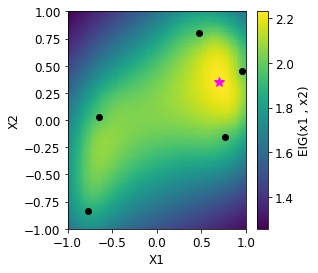

Iter: 1 out of 5


Sample: 100%|██████████| 900/900 [02:05,  7.19it/s, step size=3.50e-01, acc. prob=0.884]
/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,


Acq val: [[2.87320801]
 [2.94113513]
 [3.01249446]
 ...
 [3.00944379]
 [2.98684556]
 [2.96444888]]
Acq max: 6.172826984655273
Acq idx: 6784
Next sample: 0.70, 0.35
lengthscale: 1.8270, 0.6320
outputscale: 0.5444, 0.5846
noise: 0.0082, 0.0295


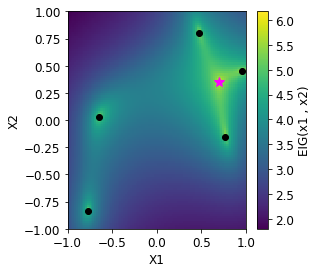

Iter: 2 out of 5


Warmup:   2%|▏         | 20/900 [00:11,  1.49it/s, step size=1.28e-01, acc. prob=0.738]/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
Warmup:   5%|▍         | 42/900 [03:17, 12.04s/it, step size=7.82e-08, acc. prob=0.628]

KeyboardInterrupt: ignored

In [58]:
iter = 5
x = input_xy
y = train_y # z values from function
priors = (1,1,1,1,1,1)

for i in range(iter):
  print(f"Iter: {i} out of {iter}")
  x_new, y_new, priors = evaluate_acq_fn(x, y, priors=priors, num_hyper_samples=600, warmup_steps=300, num_post_pred=50)

  z_new = Z(x_new, y_new)

  x = torch.cat((x, torch.tensor([[x_new, y_new]])), dim=0)
  y = torch.cat((y, torch.tensor([z_new])), dim=0)

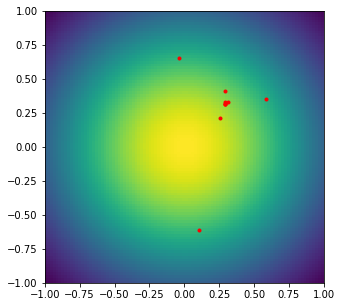

In [14]:
plt.figure(figsize=(5,5))
plt.pcolor(X, Y, Z(X,Y))
plt.plot(x[:,0], x[:,1], color="red", linewidth=0, marker=".")

In [15]:
print(x,y)

tensor([[ 0.1051, -0.6118],
        [ 0.5833,  0.3534],
        [-0.0404,  0.6537],
        [ 0.2929,  0.4141],
        [ 0.2525,  0.2121],
        [ 0.3131,  0.3333],
        [ 0.2929,  0.3333],
        [ 0.2929,  0.3131],
        [ 0.2929,  0.3131],
        [ 0.2929,  0.3131]]) tensor([0.7400, 0.6953, 0.7153, 0.8179, 0.9185, 0.8492, 0.8574, 0.8662, 0.8662,
        0.8662])
